## Embedding Driven Text Analysis of Crease's Stance Towards Chinese Immigrants

prAxIs UBC Team <br> _Kaiyan Zhang, Irene Berezin, Alex Ronczewski_

2025-8-14

### Library Loading

In [1]:
# This cell loads the necessary libraries for executing the notebook.
import pandas as pd
import numpy as np
import re
import umap
import textwrap
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from nltk import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
import spacy
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from scipy.spatial.distance import cosine
from transformers import AutoTokenizer, AutoModel, pipeline
import torch
import warnings
from collections import defaultdict, Counter
from typing import Dict, Any, Union

### Introduction

#### Overview of Historical Background

***The 1884 Chinese Regulation Act*** in British Columbia is widely regarded as one of the most notorious discriminatory provincial laws targeting Chinese immigration, it was challenged and ultimately declared unconstitutional in the 1885 case of ***R v. Wing Chong*** by the judge Henry Pering Pellew Crease. The Justice Crease found the legislation to be unconstitutional on economic grounds; infringing on federal authority over immigration, trade, commerce, treaty-making, and taxation. 

The central figure in the ruling, *Henry Pering Pellew Crease*, came from a wealthy English military family, and possessed a prestigious law background. 

* His social identity was above-all English, and this was made clear in his politics. 
* He viewed Canada not as a new society to be built, but as an extension of the british empire. 
* He displayed mistrust towards Canadians, referring to them as "North American Chinamen", afraid that they would "rule the country and job its offices" (Tina Loo).

In previous years, students expressed interest Crease's opinion on the 1884 Chinese regulation act, given that the regulation act was strongly condemned and ultimately struck down by Crease. However, this seems at odds with Crease's position on Chinese immigrants.

This raises an interesting question: **Did Judge Crease strike down the act because of genuine anti-racism concerns, or because he saw the Chinese immigrant labor force as a valuable asset for growing the Canadian economy?**

#### Objective

* We aim to explore this question by analyzing the language used by Justice Crease in his legal opinions and writings related to Chinese immigrants through **Natural Language Processing (NLP)** approaches. By examining the text, we hope to uncover insights into his stance.

* The workshop is also to demonstrate how historians can use computational tools to *help* them answer such a research question, by showing each step in the research process.

* In the end, we will be able to transform the text documents into something more intuitive and visually appealing, such as a 2D UMAP projection of the legal text embeddings by sentences. This can possibly help historians to better interpret the relationship between different texts.

![The 2D UMAP projection of legal text embeddings by sentences](../data/embedding_visualization.png)

#### The Problem: Legal Text Analysis

Legal text analysis is itself a complex task, as legal documents are often lengthy, dense, formal, and filled with specialized terminology. They are also often written in neutral or passive voice, making it difficult to discern the author's personal opinions or biases, it poses unique challenges for historians and legal scholars alike, which also challenged the usual methods of natural language processing (NLP).

Mining insights from such texts requires sophisticated techniques to extract meaningful information and identify patterns. We need the technique to be able to:
* **Understand legal vocabulary**: Legal texts often contain specialized terminology and complex sentence structures, the technique should be able to handle legal jargon and formal language.
* **Identify contextual semantics**: Legal texts often involve nuanced meanings and interpretations, so the technique should be able to capture the context and semantics of legal language.
* **Handle ambiguity**: Legal texts can be ambiguous, with multiple interpretations possible, the technique should be able to handle ambiguity and provide insights into different interpretations.
* **Extract relevant topics**: Legal texts often cover multiple topics and issues, the technique should be able to extract relevant topics and themes from the text.
* **Analyze sentiment**: Legal texts can convey different sentiments, such as positive, negative, or neutral, the technique should be able to analyze sentiment and provide insights into the author's tone and attitude.

#### Research Approach

In this workshop, we will explore how to address these challenges using a comparison approach, that is, while we focus on the text of Justice Crease, we will compare it with other legal texts from the same period to gain a better understanding of the language used in legal documents at that time.

The first subject we will use for comparison is the ***1884 Chinese Regulation Act***, which was the law that Crease struck down. The second subject we will use for comparison is **Justice Matthew Baillie Begbie**, who testified alongside Crease in the 1884 Royal Commission on Chinese Immigration.

* Unlike Crease, historical accounts describe Begbie as protective of marginalized peoples, particularly Indigenous communities and Chinese immigrants.
* Similar to what Crease did to the Chinese Regulation Act, Begbie struck down discriminatory municipal by-laws in Victoria that targeted Chinese-owned businesses in the 1888 case of ***R v. Victoria***.

We use machine learning techniques, specifically text embeddings, to do the following:

1. Compile **a corpus of legal cases and commission reports** authored by contemporary judges concerning Chinese immigrants.
2. Apply **Optical Character Recognition (OCR)** to the reports in order to convert them to a machine-readable format. 
3. Examine **keywords** in the texts, to compare the positions of different justices and regulations.
4. Use **machine learning** to assess the relative emphasis on economic versus social justice concerns.
5. Use **sentiment analysis** to evaluate the tone of the documents, focusing on whether they reflect positive, negative, or neutral sentiments, and compare the sentiments of writings by different authors to identify patterns.
6. Use **zero-shot classification** to evaluate whether the documents reflect pro-discrimination, neutral, or anti-discrimination positions.

This approach demonstrates different techniques historians can use to identify patterns in documents for analysis.

#### Data Collection and Preprocessing

We plan to use 10 digitalized texts, they are:

- Legal Documents that address Chinese immigration in BC during the period: 
    - *R v. Wing Chong* 
    - *Wong Hoy Woon v. Duncan* 
    - *R v. Mee Wah, R v. Victoria* 
    - *Chinese Regulation Act, 1884*
- Reports authored by Crease and Begbie for the Royal Commission that show the judges' personal perspectives. 
- The remaining documents enrich our corpus for analysis and supplement our study.

A big issue with working with historical texts is the format they're stored in: usually scans of varying quality from physical books, articles, etc. However, these are not machine-readable file formats (e.g., text files), so our first step will be using **Optical Character Recognition (OCR)** to convert the scanned images into machine-readable text. We chose this approach because: 

1. It is a common technique for digitizing printed texts that is already widely used in legal case archives such as the CanLii database, and 
2. There are many OCR tools available that vary in cost, effectiveness, and ease of use. 

Below is a brief overview of early and modern OCR techniques:


- **Early OCR (Pattern Matching):**

    - Compared each character image to a library of fonts and shapes.
    - Worked well for clean, printed text.
    - Struggled with handwriting, unusual fonts, or degraded scans.

- **Modern OCR (Intelligent Recognition):**

    - Uses AI to "read" text more like a human.
    - Analyzes shapes, context, and layout.
    - Handles messy, handwritten, or complex documents much better.

After testing several tools, we found that modern, AI-based OCR methods produced the most accurate results for our historical documents.

#### Data Overview

After OCR, we obtained a `.csv` file containing the text and metadata of the documents. Note that we removed the direct quotes of the *1884 Chinese Regulation Act* in Crease's ruling, as they don't reflect his own language. The structure of the data is as follows:
| Column Name                   | Description                                              |
| ----------------------------- | -------------------------------------------------------- |
| filename                    | Name of the file containing the document text.           |
| author                      | Author of the document (e.g., "Crease", "Begbie").       |
| type                        | Document type (e.g., "case", "report").                  |
| text                        | Full text of the document, which may include OCR errors. |
| act_quote_sentences_removed | Number of quoted sentences removed from the full text.   |

Here, we read the `.csv` file into a pandas DataFrame and display.

In [2]:
# Load the dataset
df = pd.read_csv("../data/metadata_cleaned.csv")

df

,filename,author,type,text,act_quote_sentences_removed
0,regina_v_wing_chong.txt,Crease,case,"CREASE, J. 1885. REGINA v. WING CHONG. \r\n\r\...",12
1,wong_hoy_woon_v_duncan.txt,Crease,case,"CREASE, J.\r\n\r\nWONG HOY WOON v. DUNCAN.\r\n...",0
2,regina_v_mee_wah.txt,Begbie,case,BRITISH COLUMBIA REPORTS.\r\n\r\nREGINA v. MEE...,0
3,regina_v_victoria.txt,Begbie,case,"OF BRITISH COLUMBIA.\r\n\r\nREGINA r, CORPORAT...",0
4,quong_wing_v_the_king.txt,Fitzpatrick,case,QUONG WING v. THE KING. CAN. \r\n\r\nSupreme ...,0
5,commission_on_chinese_imigration.txt,Powell,report,"On the 4th of July, 1884, the following Commis...",0
6,chapleau_report_resume.txt,Chapleau,report,RESUMÉ.\r\n\r\n1. That Chinese labor is a most...,0
7,crease_commission.txt,Crease,report,"The Hon. Mr. Justice CREASE, Judge of the Supr...",0
8,begbie_commission.txt,Begbie,report,"Sir MATTHEW BEGBIE, Chief Justice of British C...",0
9,chinese_regulation_act_1884.txt,Others,act,An Act to regulate the Chinese population of B...,0


We are also interested in the length of each document, as it can provide insights into the depth and complexity of the text. Therefore, we create a summary below quantifying the number of characters in each document.



In [3]:
# Summary the distribution of document lengths
# Create a DataFrame to store the document lengths
doc_lengths = []

# Measure lengths of each document by number of characters
for row in df.iterrows():
    text_length = len(row[1]['text'])
    doc_lengths.append({'Document': row[1]['filename'], 'Length': text_length})

# Convert to DataFrame and display
doc_lengths_df = pd.DataFrame(doc_lengths)
doc_lengths_df

,Document,Length
0,regina_v_wing_chong.txt,36819
1,wong_hoy_woon_v_duncan.txt,13912
2,regina_v_mee_wah.txt,25104
3,regina_v_victoria.txt,8252
4,quong_wing_v_the_king.txt,46982
5,commission_on_chinese_imigration.txt,3402
6,chapleau_report_resume.txt,10906
7,crease_commission.txt,30768
8,begbie_commission.txt,41270
9,chinese_regulation_act_1884.txt,12908


### How Computers Interpret Text?

While computers can process text swiftly, they do not "understand" it in the human sense. Instead, they build mathematical models of language from statistical patterns and structural regularities. These models produce symbolic and continuous representations of words and passages that allow downstream algorithms to detect topics, relationships, and affective signals. However, these representations remain proxies for meaning rather than literal comprehension.

This process typically involves a sequence of steps:

1. **Tokenization**: Breaking text into analyzable units (words, subwords, or sentences). 
2. **Preprocessing**: Cleaning and normalizing text (lowercasing, removing OCR noise, handling archaic spelling). 
3. **Vectorization**: Converting tokens or texts into numerical vectors. 

    - Simple count-based approaches (TF-IDF) capture term importance across documents. 
    - Modern contextual methods (BERT, Legal‑BERT) produce dense embeddings that capture usage-dependent semantics.

4. **Modeling and Comparison**: Applying algorithms to those vectors. Examples include cosine similarity for semantic closeness, UMAP for visualization, and zero‑shot classification.
5. **Aggregation and Interpretation**: Aggregating sentence- or snippet-level outputs to produce document- or author-level summaries (mean stance vectors, topic distributions), followed by careful human interpretation.

Why this is helpful for social science and humanities research:

- **Scalability**: Enables analysis of large corpora beyond human reading capacity.
- **Pattern Discovery**: Uncovers latent structures and relationships not easily seen by humans.
- **Quantification**: Provides numerical measures of abstract concepts (e.g., sentiment, stance).
- **Reproducibility**: Offers systematic, repeatable methods for text analysis.

#### Count Approach: TF-IDF

The **Term Frequency-Inverse Document Frequency (TF-IDF)** is a statistical measure that evaluates the importance of a word in a document relative to a collection of documents (corpus). It is one of the earliest and most widely used methods for text analysis. It is essentially a count-based approach that quantifies the importance of words in a document based on their frequency and distribution across multiple documents. TF-IDF works by calculating two components:
1. **Term Frequency (TF)**: Measures how frequently a term appears in a document.
2. **Inverse Document Frequency (IDF)**: Measures how important a term is across the entire corpus, by considering how many documents contain the term.

For our purpose, we can use TF-IDF to identify the most important words in each document, which can help us understand the key themes and topics discussed in the text. More details on what we are going to do:

1. Regroup the text data into 5 groups:
    - All writings
    - Crease's writings
    - Begbie's writings
    - Chinese Regulation Act
    - Other documents
2. For each group, we will: 
    - Create a TF-IDF vectorizer to convert the text into numerical vectors.
    - Remove common filler words ("the", "and", etc.).
    - Calculate the TF-IDF scores for each word in the documents.
    - Identify the most important words based on their TF-IDF scores.
3. The most frequent remaining words can reveal the main topics of each case.

In [4]:
# Define the function to preprocess text in a DataFrame column
def preprocess_text(text_string):
    """
    Cleans and preprocesses text by:
    1. Converting to lowercase
    2. Removing punctuation and numbers
    3. Tokenizing
    4. Removing English stop words 
    5. Removing words with 4 or fewer characters
    """
    # Start with the standard English stop words
    stop_words = set(stopwords.words('english'))
    
    # Add custom domain-specific stop words if needed
    custom_additions = {'would', 'may', 'act', 'mr', 'sir', 'also', 'upon', 'shall'}
    stop_words.update(custom_additions)
    
    # Lowercase and remove non-alphabetic characters
    processed_text = text_string.lower()
    processed_text = re.sub(r'[^a-z\s]', '', processed_text)
    
    # Tokenize
    tokens = processed_text.split()
    
    # Filter out stop words AND short words in a single step
    filtered_tokens = [
        word for word in tokens 
        if word not in stop_words and len(word) > 4
    ]
    # Re-join the words into a single string
    return " ".join(filtered_tokens)

In [5]:
# Apply the function to create the 'processed_text' column
df['processed_text'] = df['text'].apply(preprocess_text)

# Display the first few rows of the processed text
df['processed_text'].head(5)

0    crease regina chong certiorarichinese regulati...
1    crease duncan health regulationsvictoria healt...
2    british columbia reports regina begbie constit...
3    british columbia regina corporation victoria p...
4    quong supreme court canada charles fitzpatrick...
Name: processed_text, dtype: object

In [6]:
# Perform TF-IDF vectorization on the processed text

# Regrouping the DataFrame for better representation
df['group'] = 'Other'
df.loc[df['author'] == 'Crease', 'group'] = 'Crease'
df.loc[df['author'] == 'Begbie', 'group'] = 'Begbie'
df.loc[df['author'] == 'Others', 'group'] = 'Regulation Act'

# Load the vectorizer and transform the processed text
# This calculates IDF based on word rarity across ALL individual texts.
vectorizer = TfidfVectorizer(max_features=1000, ngram_range=(1, 3))
tfidf_matrix = vectorizer.fit_transform(df['processed_text'])

# Create a new DataFrame with the TF-IDF scores
feature_names = vectorizer.get_feature_names_out()
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=feature_names)

# Add the 'group' column to this TF-IDF DataFrame for aggregation
tfidf_df['group'] = df['group'].values

# Group by author and calculate the MEAN TF-IDF score for each word
mean_tfidf_by_group = tfidf_df.groupby('group').mean()

# Calculate TF-IDF for the combined corpus ("All") using the same vectorizer
processed_all = " ".join(df['processed_text'])
all_vec = vectorizer.transform([processed_all]).toarray().ravel()
all_series = pd.Series(all_vec, index=feature_names, name='All')

# Add the "All" row to the grouped TF-IDF DataFrame
mean_tfidf_by_group = pd.concat([all_series.to_frame().T, mean_tfidf_by_group], axis=0)

# Collect top words and arrange them into a side-by-side DataFrame
list_of_author_dfs = []
for group_name in ['All', 'Crease', 'Begbie', 'Regulation Act', 'Other']:
    if group_name not in mean_tfidf_by_group.index:
        # If a group is missing, append an empty frame to keep column alignment
        empty_df = pd.DataFrame({group_name: [], f'{group_name}_score': []})
        list_of_author_dfs.append(empty_df)
        continue

    # Get the top 10 terms and scores for the current author/group
    top_words = mean_tfidf_by_group.loc[group_name].sort_values(ascending=False).head(10)

    # Convert the Series to a DataFrame
    top_words_df = top_words.reset_index()
    top_words_df.columns = [group_name, f'{group_name}_score']

    list_of_author_dfs.append(top_words_df)

# Concatenate the list of DataFrames horizontally
final_wide_df = pd.concat(list_of_author_dfs, axis=1)

# Display the final combined DataFrame (includes "All")
final_wide_df

,All,All_score,Crease,Crease_score,Begbie,Begbie_score,Regulation Act,Regulation Act_score,Other,Other_score
0,chinese,0.280580,chinese,0.200601,license,0.227563,chinese,0.443315,canada,0.221373
1,labor,0.166859,labor,0.168550,chinamen,0.149219,dollars,0.283191,chinese,0.194695
2,white,0.164720,infected,0.134599,licenses,0.132835,licence,0.247792,legislation,0.137609
3,british,0.147600,white,0.126402,municipality,0.113449,collector,0.212393,country,0.114030
4,chinamen,0.142068,taxation,0.103640,statute,0.103499,forfeit,0.190386,wycombe,0.110548
5,legislation,0.141805,british,0.096680,legislature,0.098062,lieutenantgovernor,0.190386,naturalized,0.107645
6,aliens,0.140237,hongkong,0.096142,revenue,0.096895,person,0.190158,great,0.101984
7,taxation,0.131823,dominion,0.092252,corporation,0.093189,possession,0.188833,parliament,0.097260
8,naturalized,0.126213,health officer,0.089733,pawnbrokers,0.085087,exceeding,0.176994,county,0.093976
9,within,0.118634,china,0.089049,provincial,0.084027,lieutenantgovernor council,0.166587,honorable,0.092710


Undoubtedly, the TF-IDF practice on our corpus has identified some interesting patterns, such as: 

- The emphasis on "Chinese" in all groups. 
- The emphasis on "labor" in Crease's writings. 
- The emphasis on "license" in Begbie's writings. 
- And the emphasis on "dollars" in the Chinese Regulation Act. 
- Other texts put "Canada" on the top of the list, and "legislation" right after "Chinese".

However, this approach has limitations, as it does not capture the semantic meaning of words or their relationships to each other. For example, it cannot distinguish between "Chinese" as a noun and "Chinese" as an adjective, or between "labor" as a noun and "labor" as a verb. It also does not consider the context in which words are used, which can lead to misinterpretation of their meaning.

#### Embedding Approach

With the advancement of machine learning, **text embeddings** emerged as a more powerful technique for text analysis. It represents words or phrases as dense vectors in a high-dimensional space, capturing semantic relationships between them. This allows for more nuanced understanding of text, enabling tasks like similarity measurement, clustering, and classification.

There are several popular text embedding models, including:
- **Word2Vec**: A neural network-based model that learns word embeddings by predicting context words given a target word (or vice versa).
- **GloVe**: A global vector representation model that learns word embeddings by factorizing the word co-occurrence matrix.
- **FastText**: An extension of Word2Vec that represents words as bags of character n-grams, allowing it to handle out-of-vocabulary words and capture subword information.
- **BERT**: A transformer-based model that generates contextualized embeddings by considering the entire sentence context, allowing it to capture word meanings based on their surrounding words.

In this workshop, we will use a BERT-based model to generate text embeddings for our corpus. [nlpaueb/legal-bert-base-uncased](https://huggingface.co/nlpaueb/legal-bert-base-uncased) is a BERT model pre-trained on English legal texts, including legislation, law cases, and contracts. It is designed to capture the legal language and semantics, making it suitable for our analysis. 

However, we must note that the model is not perfect and may still have limitations in understanding the nuances of legal language, especially in historical texts. 

### Word Embeddings
#### Creating Word Embeddings

While the model itself has the ability to generate word embeddings that capture the semantic meaning of words, we still need to design our own strategy to extract these meanings from our corpus. 

- Load LEGAL-BERT model and tokenizer.
- Tokenize sentences into smaller subword units using a tokenizer.
- Process each tokenized sentence through the model to extract hidden layer representations.
- Combine subword embeddings to form a single vector for each word by averaging the embeddings of its subword components.
- Aggregate embeddings for repeated words across sentences by averaging their vectors.
- Return a dictionary mapping each word to its mean embedding, capturing its semantic meaning in the context of the text.

In this way, we are not only able to generate word embeddings with contextual meanings over the whole corpus, but also be able to aggregate our corpus into different groups, and generate contextualized word embeddings for each group.

In [7]:
# We will use the Legal-BERT model for this task
tokenizer = AutoTokenizer.from_pretrained('nlpaueb/legal-bert-base-uncased')
model = AutoModel.from_pretrained('nlpaueb/legal-bert-base-uncased').eval() # set the model to evaluation mode

# Define a function to embed words using the tokenizer and model
def embed_words(sentences, tokenizer=tokenizer, model=model, target_words=None,
                device=None, max_length=512):
    """
    Returns a dictionary {word: mean_embedding}.
    Only the mean embedding (float32 numpy array) per word is kept.
    """
    if device is None:
        try:
            device = next(model.parameters()).device
        except Exception:
            device = torch.device("cpu")
    device = torch.device(device)
    model.to(device).eval()

    target_set = None if target_words is None else set(target_words)

    sums = {}   # word -> torch.Tensor sum of embeddings
    counts = {} # word -> occurrence count

    with torch.no_grad():
        for sent in sentences:
            enc = tokenizer(
                sent,
                return_tensors="pt",
                truncation=True,
                max_length=max_length
            )
            enc = {k: v.to(device) for k, v in enc.items()}
            outputs = model(**enc)
            hidden = outputs.last_hidden_state.squeeze(0)  # (seq_len, hidden)
            tokens = tokenizer.convert_ids_to_tokens(enc["input_ids"][0])

            i = 0
            while i < len(tokens):
                tok = tokens[i]
                if tok in ("[CLS]", "[SEP]", "[PAD]"):
                    i += 1
                    continue

                # Gather wordpieces
                j = i + 1
                piece_embs = [hidden[i]]
                word = tok[2:] if tok.startswith("##") else tok
                while j < len(tokens) and tokens[j].startswith("##"):
                    piece_embs.append(hidden[j])
                    word += tokens[j][2:]
                    j += 1

                if target_set is not None and word not in target_set:
                    i = j
                    continue

                word_emb = torch.stack(piece_embs, dim=0).mean(dim=0)
                if word in sums:
                    sums[word] += word_emb
                    counts[word] += 1
                else:
                    sums[word] = word_emb.clone()
                    counts[word] = 1
                i = j

    return {w: (sums[w] / counts[w]).cpu().numpy() for w in sums}


In [8]:
# Define a function to clean and preprocess text
def clean_text(text):
    
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    
    return text.strip()

In [9]:
warnings.filterwarnings("ignore")

nlp = spacy.load("en_core_web_sm")

# Group texts to form a single text per group
grouped_texts = df.groupby('group')['text'].apply(lambda x: ' '.join(x)).reset_index()

# Add a row for the combined text of all groups
grouped_texts = pd.concat(
    [grouped_texts, pd.DataFrame([{'group': 'All', 'text': ' '.join(df['text'])}])],
    ignore_index=True
)

# Create new columns for word and sentence tokens
grouped_texts['word_tokens'] = grouped_texts['text'].apply(lambda x: word_tokenize(clean_text(x)))
# Sentence tokenization using spaCy
grouped_texts['sentence_tokens'] = grouped_texts['text'].apply(lambda x: [sent.text for sent in nlp(x).sents])

# Apply clean_text to the sentence tokens
grouped_texts['sentence_tokens'] = grouped_texts['sentence_tokens'].apply(
    lambda x: [clean_text(sent) for sent in x]
)

In [10]:
# Embed the words in each group
grouped_texts['word_embeddings'] = grouped_texts['sentence_tokens'].apply(
    lambda x: embed_words(x)
    )

# Compute the number of unique words in each group
grouped_texts['num_unique_words'] = grouped_texts['word_tokens'].apply(lambda x: len(set(x)))

grouped_texts.head()

,group,text,word_tokens,sentence_tokens,word_embeddings,num_unique_words
0,Begbie,BRITISH COLUMBIA REPORTS.\r\n\r\nREGINA v. MEE...,"[british, columbia, reports, regina, v, mee, w...","[british columbia reports, regina v mee wah be...","{'british': [0.20316587, 0.13844684, 0.0951799...",2622
1,Crease,"CREASE, J. 1885. REGINA v. WING CHONG. \r\n\r\...","[crease, j, 1885, regina, v, wing, chong, 14th...","[crease j 1885, regina v wing chong, 14th 15t...","{'crease': [0.4296904, 0.2745006, 0.581529, -0...",2654
2,Other,QUONG WING v. THE KING. CAN. \r\n\r\nSupreme ...,"[quong, wing, v, the, king, can, supreme, cour...","[quong wing v the king, can, supreme court of ...","{'quong': [-0.0015669838, 0.3608557, 0.3371874...",1906
3,Regulation Act,An Act to regulate the Chinese population of B...,"[an, act, to, regulate, the, chinese, populati...",[an act to regulate the chinese population of ...,"{'an': [-0.19208689, -0.12014979, -0.17713086,...",576
4,All,"CREASE, J. 1885. REGINA v. WING CHONG. \r\n\r\...","[crease, j, 1885, regina, v, wing, chong, 14th...","[crease j 1885, regina v wing chong, 14th 15t...","{'crease': [0.32874852, 0.41524658, 0.48175654...",4849


We created word embeddings of all tokens in each group, respectively. The word embeddings are stored in a dictionary format, where each key is a word and the value is its corresponding embedding vector.

It is clear that the word embeddings of the same word in different groups are different, which reflects the contextualized meaning of the word in each group. 

- For example, the word "Chinese" has a different embedding in Crease's writings compared to Begbie's writings, indicating that the two authors used the word in different contexts and with different connotations.
- However, since they were embedded using the same model, the word embeddings of the same word in different groups are still similar, which reflects the shared meaning of the word across different contexts.
- The dimensionality of all word embeddings is 768, which is the size of the hidden layer in the LEGAL-BERT model we used.

In [11]:
# Display the word embedding of Chinese for the whole corpus
chinese_embedding = grouped_texts[grouped_texts['group'] == 'All']['word_embeddings'].values[0].get('chinese')

# Display first 20 dimensions for brevity
print(f"First 20 Dimensions of Word Embedding for 'Chinese' in the Full Corpus:\n {chinese_embedding[:20]}\n")
print(f"Total Dimensions of Word Embedding for 'Chinese': {len(chinese_embedding)}\n")

First 20 Dimensions of Word Embedding for 'Chinese' in the Full Corpus:
 [ 0.12668514  0.26626247  0.06976263  0.03987848  0.3198149   0.12648065
  0.1179221   0.25096533 -0.24571839 -0.09690513  0.06757622  0.46853873
  0.00413261 -0.08175131 -0.42389032  0.25379455  0.11806588 -0.129208
 -0.60333675  0.4287366 ]

Total Dimensions of Word Embedding for 'Chinese': 768



In [12]:
# Display the word embedding of Chinese in Crease's text
crease_embeddings = grouped_texts[grouped_texts['group'] == 'Crease']['word_embeddings'].values[0]
# Display first 20 dimensions for brevity
print(f"First 20 Dimensions of Word Embeddings for 'Chinese' in Crease's Text:\n{crease_embeddings.get('chinese')[:20]}\n") 
print(f"Total Dimensions of Word Embeddings for 'Chinese' in Crease's Text: {len(crease_embeddings.get('chinese'))}\n")

First 20 Dimensions of Word Embeddings for 'Chinese' in Crease's Text:
[ 0.1207148   0.31710652  0.04701388  0.07962938  0.30281344  0.09768455
  0.14006759  0.2546475  -0.22537379 -0.09438673  0.0616338   0.49788
  0.00510495 -0.07701945 -0.4433001   0.3088299   0.0834146  -0.12817031
 -0.56065226  0.4199316 ]

Total Dimensions of Word Embeddings for 'Chinese' in Crease's Text: 768



In [13]:
begbie_embeddings = grouped_texts[grouped_texts['group'] == 'Begbie']['word_embeddings'].values[0]
# Display first 20 dimensions for brevity
print(f"First 20 Dimensions of Word Embeddings for 'Chinese' in Begbie's Text:\n{begbie_embeddings.get('chinese')[:20]}\n")
print(f"Total Dimensions of Word Embeddings for 'Chinese' in Begbie's Text: {len(begbie_embeddings.get('chinese'))}\n")

First 20 Dimensions of Word Embeddings for 'Chinese' in Begbie's Text:
[ 0.13345422  0.28776637  0.01769559 -0.01827072  0.30239815  0.16497923
  0.01982685  0.31021848 -0.2716136   0.00533469  0.05232281  0.4485962
 -0.04535438 -0.05225528 -0.52643675  0.36453673  0.16012253 -0.15775643
 -0.59051466  0.37558916]

Total Dimensions of Word Embeddings for 'Chinese' in Begbie's Text: 768



#### Measurement of Similarity

Another important aspect of word embeddings is the ability to measure the similarity between words based on their embeddings. This can be done using cosine similarity, which calculates the cosine of the angle between two vectors in the embedding space. The cosine similarity ranges from 0 to 1, where:

- 0 indicates no similarity (orthogonal vectors)
- 1 indicates perfect similarity (identical vectors)
- The closer the cosine similarity is to 1, the more similar the words are in meaning.

This allows us to identify related words and concepts based on their embeddings, enabling us to explore the semantic relationships between words in our corpus. And more importantly, it doesn't only allows us to measure the similarity between words, but also allows us to measure the similarity between sentences, paragraphs, and even entire documents, as long as they are represented as vectors in the same embedding space.

The math behind cosine similarity is as follows:
$$
\text{cosine similarity}(a, b) = \frac{a \cdot b}{||a|| \cdot ||b||}
$$
Where $a$ and $b$ are the embedding vectors of the two words, and $||a||$ and $||b||$ are their Pythagorean norms (lengths).

Focusing on the word "Chinese", we can calculate its cosine similarity with other words in the same group to identify related terms. This can help us understand how the word is used in different contexts and how it relates to other concepts. Here, we will list out the top 10 most similar words to "Chinese" in each group, along with their cosine similarity scores.

**Note**: All words are put into lowercase.

In [14]:
# Compute top-10 most similar words to target for EVERY group (including "All")
target = "chinese"
top_n = 10
all_results = []
# Iterate through each group and compute similarities
for _, grp_row in grouped_texts.iterrows():
    group = grp_row['group']
    emb_dict = grp_row['word_embeddings']
    if target not in emb_dict:
        continue
    target_vec = emb_dict[target]
    sims = []
    for w, vec in emb_dict.items():
        if w == target:
            continue
        try:
            sim = 1 - cosine(target_vec, vec)
        except Exception:
            continue
        sims.append((w, sim))
    sims_sorted = sorted(sims, key=lambda x: x[1], reverse=True)[:top_n]
    for rank, (w, sim) in enumerate(sims_sorted, 1):
        all_results.append({'group': group, 'rank': rank, 'word': w, 'similarity': sim})  # Use :4f for better readability

similar_words_df = pd.DataFrame(all_results)

# Display the first few rows of the DataFrame with similar words
sims_wide = similar_words_df.pivot(index='rank', columns='group', values='similarity')
words_wide = similar_words_df.pivot(index='rank', columns='group', values='word')

# Combine with a tidy multi-level column index: 
wide_combined = pd.concat({'word': words_wide, 'similarity': sims_wide}, axis=1)
wide_combined = (
    wide_combined.swaplevel(0,1, axis=1)
                 .sort_index(axis=1, level=0)
)

wide_combined  # Display


group        All                 Begbie                 Crease                 \
      similarity        word similarity        word similarity           word   
rank                                                                            
1       0.882441    chinamen   0.876610       china   0.884398       chinamen   
2       0.879673    chinaman   0.869450    chinamen   0.876641       chinaman   
3       0.878318       china   0.866369    chinaman   0.866081          china   
4       0.833719    japanese   0.816941      whites   0.857200          white   
5       0.833196       white   0.811970       white   0.846658         aliens   
6       0.833099  immigrants   0.798483     english   0.816191  confederation   
7       0.831805   immigrant   0.797803   europeans   0.816176        coolies   
8       0.830697      whites   0.796832   universal   0.815357     immigrants   
9       0.822064      aliens   0.791045      canton   0.814903          sweet   
10      0.820433       alien   0.789463  provincial   0.813782       japanese   

group      Other             Regulation Act             
      similarity        word     similarity       word  
rank                                                    
1       0.877303       china       0.759336  immigrant  
2       0.876505    chinamen       0.744862   employer  
3       0.870729    chinaman       0.740853     whites  
4       0.815160   orientals       0.739350     native  
5       0.812049      aliens       0.734878     person  
6       0.810886       alien       0.726807      yards  
7       0.810220  immigrants       0.710742  emergency  
8       0.804136     asiatic       0.708795    licence  
9       0.803130  provincial       0.708284      found  
10      0.803034    oriental       0.708163       race

### Embedding Driven Text Analysis
#### Creating Keyword-Focused Stance Embeddings

In comparison to generating word embeddings, modeling stance of each text is more challenging, as it requires us to capture the author's position on a specific issue or topic. Oftentimes, the stance is not explicitly stated in the text, but rather implied through the language used. 

There is not a universal optimum for stance modeling, as it depends on the specific context and the author's perspective. However, we can use a combination of techniques to create focused embeddings that capture the stance of each text. The strategy we used is as follows:

1. Tokenize the text into smaller units and identify the positions of specific keywords or phrases that are relevant to the stance being analyzed.
2. For each occurrence of the keywords, extract a surrounding "window" of text to capture the context in which the keywords are used.
3. Represent the text in the window as numerical vectors using a pre-trained language model, which encodes the meaning of the words and their relationships.
4. Combine the vectors within each window using a pooling method (e.g., averaging or selecting the maximum value) to create a single representation for the context around the keyword.
5. If multiple occurrences of the keywords are found, average their representations to create a unified vector that captures the overall stance in the text.
6. If no keywords are found, use a fallback representation based on the overall text.

This approach thus allows us to create focused embeddings that capture the stance of each text focusing on specific keywords or phrases. The sentence is used as the basic unit of analysis here, but larger chunks of text can also be used if needed. 

In the end, we will store the lists of embeddings in a dictionary format, where each key is the author and the value is a list of embeddings for each text authored by that author.

In [15]:
def embed_text(
    text,
    focus_token= None,
    window = 10,
    pooling = "mean",  # "mean" (default), "max", or "min"
    tokenizer=tokenizer,
    model=model):

    # Run the model once
    inputs = tokenizer(text, return_tensors="pt", truncation=True)
    with torch.no_grad():
        outputs = model(**inputs)
    hidden = outputs.last_hidden_state.squeeze(0) 

    if focus_token is None:
        return hidden[0].cpu().numpy()
    
    # Normalize to list
    keywords = (
        [focus_token] if isinstance(focus_token, str)
        else focus_token
    )

    # Pre-tokenize each keyword to its subtoken ids
    kw_token_ids = {
        kw: tokenizer.convert_tokens_to_ids(tokenizer.tokenize(kw))
        for kw in keywords
    }

    input_ids = inputs["input_ids"].squeeze(0).tolist()
    spans = []  # list of (start, end) index pairs

    # find every match of every keyword
    for kw, sub_ids in kw_token_ids.items():
        L = len(sub_ids)
        for i in range(len(input_ids) - L + 1):
            if input_ids[i:i+L] == sub_ids:
                spans.append((i, i+L))

    if not spans:
        # fallback on CLS vector
        return hidden[0].cpu().numpy()

    # For each span, grab the window around it
    vecs = []
    for (start, end) in spans:
        lo = max(1, start - window)
        hi = min(hidden.size(0), end + window)
        # mean‑pool over all tokens in this extended window
        span_vec = hidden[lo:hi]
        
        if pooling == "mean":
            pooled = span_vec.mean(dim=0)
        elif pooling == "max":
            pooled = span_vec.max(dim=0).values
        elif pooling == "min":
            pooled = span_vec.min(dim=0).values
        else:
            raise ValueError(f"Unknown pooling method: {pooling}")
        
        vecs.append(pooled.cpu().numpy())

    # Average across all spans
    return np.mean(np.stack(vecs, axis=0), axis=0)

In [16]:
crease_cases = df[(df['author'] == 'Crease') & (df['type'] == 'case')]['text'].tolist()
begbie_cases = df[(df['author'] == 'Begbie') & (df['type'] == 'case')]['text'].tolist()
act_1884 = df[df['type'] == 'act']['text'].tolist()

act_dict = {
    'Crease': crease_cases,
    'Begbie': begbie_cases,
    'Act 1884': act_1884}

In [18]:
act_snippets = {}

keywords = ["Chinese", "China", "Chinaman", "Chinamen", 
            "immigrant", "immigrants", "alien", "aliens", 
            "immigration"]

for auth, texts in act_dict.items():
    snippets = []
    for txt in texts:
        # Sentence tokenize using Spacy
        sentence = [sent.text for sent in nlp(txt).sents]
        for sent in sentence:
            if any(keyword in sent for keyword in keywords):
                snippets.append(sent)
    act_snippets[auth] = snippets

In [19]:
# Investigate the length of the snippets
n_snippet = {auth: len(snippets) for auth, snippets in act_snippets.items()}

print("Snippet size by author:")
for auth, num in n_snippet.items():
    print(f"{auth}: {num}")

Snippet size by author:
Crease: 83
Begbie: 18
Act 1884: 24


In [20]:
# Create embeddings
embeddings_dict = {'Crease': [], 'Begbie': [], 'Act 1884': []}

for auth, snippets in act_snippets.items():
    for snip in snippets:
        v = embed_text(snip, focus_token=keywords, window=15)
        embeddings_dict[auth].append(v) 

#### Measuring Stance Similarity

Just like word embeddings, cosine similarity can also be used to measure the stance similarity between texts. The interpretation of cosine similarity in this context is similar to that of word embeddings, where a higher cosine similarity indicates a stronger alignment in stance between two texts.

With sentence being the basic unit of analysis, we can calculate the overall cosine similarity between each pair of authors' texts in various ways, but here we will focus on two of them:
1. **Mean Embeddings**: We calculate the mean embedding for each author's texts and then compute the cosine similarity between these mean embeddings. This gives us a single similarity score for each pair of authors, reflecting their overall stance alignment.
2. **Pairwise Embeddings**: We calculate the cosine similarity between each pair of texts authored by different authors, then average the scores to get a more comprehensive view of stance alignment across all texts.

Note that similarity scores are not deterministic, as they depend on the specific texts and the context in which the keywords are used. However, they can provide valuable insights into the stance of each author and how it relates to other authors' positions. This reinforces the idea that **stance is not a fixed attribute**, but rather a dynamic and context-dependent aspect of language.

In [21]:
# Compute the pairwise cosine similarity
mean_crease = np.mean(embeddings_dict["Crease"], axis=0, keepdims=True)
mean_begbie = np.mean(embeddings_dict["Begbie"], axis=0, keepdims=True)
mean_act_1884 = np.mean(embeddings_dict["Act 1884"], axis=0, keepdims=True)

sim_crease_begbie = cosine_similarity(mean_crease, mean_begbie)[0, 0]
sim_crease_act_1884 = cosine_similarity(mean_crease, mean_act_1884)[0, 0]
sim_begbie_act_1884 = cosine_similarity(mean_begbie, mean_act_1884)[0, 0]

print(f"Cosine similarity between mean Crease and mean Begbie: {sim_crease_begbie:.4f}")
print(f"Cosine similarity between mean Crease and mean Act 1884: {sim_crease_act_1884:.4f}")
print(f"Cosine similarity between mean Begbie and mean Act 1884: {sim_begbie_act_1884:.4f}")

Cosine similarity between mean Crease and mean Begbie: 0.9891
Cosine similarity between mean Crease and mean Act 1884: 0.9661
Cosine similarity between mean Begbie and mean Act 1884: 0.9639


In [22]:
# Extract embeddings for Crease, Begbie and the Act 1884
crease_embeddings = embeddings_dict["Crease"]
begbie_embeddings = embeddings_dict["Begbie"]
act_1884_embeddings = embeddings_dict["Act 1884"]

# Define a function to compute mean cosine similarity
def mean_cosine_similarity(embeddings1, embeddings2):
    similarities = [
        1 - cosine(e1, e2)
        for e1 in embeddings1
        for e2 in embeddings2
    ]
    return sum(similarities) / len(similarities)

# Extract embeddings
crease_emb = embeddings_dict["Crease"]
begbie_emb = embeddings_dict["Begbie"]
act_1884_emb = embeddings_dict["Act 1884"]

# Compute mean similarities
crease_begbie_sim = mean_cosine_similarity(crease_emb, begbie_emb)
crease_act_sim = mean_cosine_similarity(crease_emb, act_1884_emb)
begbie_act_sim = mean_cosine_similarity(begbie_emb, act_1884_emb)

# Output
print(f"Mean cosine similarity between Crease and Begbie embeddings: {crease_begbie_sim:.4f}")
print(f"Mean cosine similarity between Crease and Act 1884 embeddings: {crease_act_sim:.4f}")
print(f"Mean cosine similarity between Begbie and Act 1884 embeddings: {begbie_act_sim:.4f}")

Mean cosine similarity between Crease and Begbie embeddings: 0.8674
Mean cosine similarity between Crease and Act 1884 embeddings: 0.8398
Mean cosine similarity between Begbie and Act 1884 embeddings: 0.8428


#### Visualizing Text Embeddings

While the embeddings themselves are high-dimensional vectors (in our case, 768-dimensional), we can visualize them in a lower-dimensional space (e.g., 2D or 3D) using **dimensionality reduction** techniques such as **UMAP** (Uniform Manifold Approximation and Projection). 

**UMAP** is a dimensionality reduction technique that projects high-dimensional embeddings into a 2D space while preserving local structure, making it ideal for visualizing our embeddings. 

Using **Plotly Express**, we create an interactive scatter plot where each point represents a text snippet, colored by author, with hover functionality to display the corresponding sentence. This visualization highlights clusters and relationships between snippets, offering insights into semantic similarities across authors.


In [23]:
# Set seed for umap reproducibility
all_vecs = np.vstack(embeddings_dict["Crease"] + embeddings_dict["Begbie"] + embeddings_dict["Act 1884"])
labels  = (["Crease"] * len(embeddings_dict["Crease"])) + (["Begbie"] * len(embeddings_dict["Begbie"])) + (['Act 1884'] * len(embeddings_dict["Act 1884"]))

reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, random_state=42)
proj = reducer.fit_transform(all_vecs) 

def wrap_text(text, width=60):
    return '<br>'.join(textwrap.wrap(text, width=width))

In [24]:
umap_df = pd.DataFrame(proj, columns=['UMAP 1', 'UMAP 2'])
umap_df['Author'] = labels
umap_df['Text'] = [snip for auth in act_snippets for snip in act_snippets[auth]]
umap_df['Text'] = umap_df['Text'].apply(lambda t: wrap_text(t, width=60))

fig = px.scatter(umap_df, x='UMAP 1', y='UMAP 2', 
                 color='Author', hover_data=['Text'], 
                 width=800, height=500 )
fig.update_traces(marker=dict(size=5))
fig.update_layout(title='UMAP Projection of Word Embeddings by Author')
fig.show()

#### Investigating Texts

The stance embeddings ultimately serve as analytical tools to support our text analysis objectives. 

- By calculating the "conceptual mean stance" for each author, we gain a quantitative basis for comparing the positions of different authors. 
- However, embeddings alone cannot fully capture the nuances of language or the complexity of an author's stance. To truly understand the perspectives reflected in the texts, it is essential to investigate the sentences that are most similar to the conceptual average position of each author.

Here, we will examine the top 10 sentences with the highest stance similarity to the mean stance of each author. 

This approach allows us to delve deeper into the texts, uncovering how the language used aligns with the calculated average stance and providing richer insights into the authors' positions on the issue of Chinese immigrants.

In [25]:
# Print out the 10 most similar embedding sentences to Crease's mean embedding

crease_similarity_df = pd.DataFrame(columns=['Author', 'Text', 'Similarity Score'])

# Iterate through the embeddings and their corresponding sentences
for auth, snippets in act_snippets.items():
    for snippet, emb in zip(snippets, embeddings_dict[auth]):
        similarity = cosine_similarity(emb.reshape(1, -1), mean_crease)[0][0]
        crease_similarity_df.loc[len(crease_similarity_df)] = [auth, snippet, similarity]
        
# Sort by similarity score
crease_sorted_similarity = crease_similarity_df.sort_values(by='Similarity Score', ascending=False)

print("Top 10 most similar sentences to Crease's mean embedding:\n")
for _, row in crease_sorted_similarity.head(10).iterrows():
    wrapped_para = textwrap.fill(row['Text'], width=100)
    print(f"Author: {row['Author']}\nSentence: {wrapped_para}\nSimilarity Score: {row['Similarity Score']:.4f}\n")

Top 10 most similar sentences to Crease's mean embedding:

Author: Crease
Sentence: The Act is found associated with another Act now disallowed, the express object of which is to
prevent the Chinese altogether from coming to this country, and the principle "noscitur a sociis" is
kept up by the preamble of the present Act, which describes the Chinese in terms which, I venture to
think, have never before in any other country found a place in an Act of Parliament.
Similarity Score: 0.9651

Author: Crease
Sentence: Another statute (of 1878), "An Act to provide for the better collection of taxes from Chinese,"
which contained several of the stringent provisions which I have described in this Act, such as a
special tax specially recoverable by summary and unusual remedies from the Chinese alone, in British
Columbia, and enforced by fine and imprisonment and other penal clauses, came before this Court, and
in a most conscientious and exhaustive judgment of Mr. Justice Gray, of 23rd September,

In [26]:
# Print out the 10 most similar embedding sentences to Begbie's mean embedding

begbie_similarity_df = pd.DataFrame(columns=['Author', 'Text', 'Similarity Score'])

# Iterate through the embeddings and their corresponding sentences
for auth, snippets in act_snippets.items():
    for snippet, emb in zip(snippets, embeddings_dict[auth]):
        similarity = cosine_similarity(emb.reshape(1, -1), mean_begbie)[0][0]
        begbie_similarity_df.loc[len(begbie_similarity_df)] = [auth, snippet, similarity]
        
# Sort by similarity score
begbie_sorted_similarity = begbie_similarity_df.sort_values(by='Similarity Score', ascending=False)

print("Top 10 most similar sentences to Begbie's mean embedding:\n")
for _, row in begbie_sorted_similarity.head(10).iterrows():
    wrapped_para = textwrap.fill(row['Text'], width=100)
    print(f"Author: {row['Author']}\nSentence: {wrapped_para}\nSimilarity Score: {row['Similarity Score']:.4f}\n")

Top 10 most similar sentences to Begbie's mean embedding:

Author: Begbie
Sentence: Statutes were by their title and preamble  expressly aimed at Chinamen by name; that this
distinction also renders inapplicable all the United States' cases cited; that this enactment is
quite general extending to all laundries without exception and we must not look beyond the words of
the enactment to enquire what its object was; that there is in fact one laundry in Victoria not
conducted by Chinamen on which the tax will fall with equal force so that it is impossible to say
that Chinamen are hereby exclusively selected for taxation; the circumstance that they are chiefly
affected being a mere coincidence; that the bylaw only imposes $100.00 per annum, keeping far within
the limit of $150.00 permitted by the Statute; that the tax clearly is calculated to procuring
additional Municipal revenue and that no other object is hinted at.
Similarity Score: 0.9674

Author: Begbie
Sentence: no other description 

In [27]:
# Print out the 10 most similar embedding sentences to the Regulation Act's mean embedding

regulation_similarity_df = pd.DataFrame(columns=['Author', 'Text', 'Similarity Score'])

# Iterate through the embeddings and their corresponding sentences
for auth, snippets in act_snippets.items():
    for snippet, emb in zip(snippets, embeddings_dict[auth]):
        similarity = cosine_similarity(emb.reshape(1, -1), mean_act_1884)[0][0]
        regulation_similarity_df.loc[len(regulation_similarity_df)] = [auth, snippet, similarity]
        
# Sort by similarity score
regulation_sorted_similarity = regulation_similarity_df.sort_values(by='Similarity Score', ascending=False)

print("Top 10 most similar sentences to the Regulation Act's mean embedding:\n")
for _, row in regulation_sorted_similarity.head(10).iterrows():
    wrapped_para = textwrap.fill(row['Text'], width=100)
    print(f"Author: {row['Author']}\nSentence: {wrapped_para}\nSimilarity Score: {row['Similarity Score']:.4f}\n")

Top 10 most similar sentences to the Regulation Act's mean embedding:

Author: Act 1884
Sentence: In case any employer of Chinese fails to deliver to the Collector the list mentioned in the
preceding section, when required so to do, or knowingly states anything falsely therein, such
employer shall, on complaint of the Collector and upon conviction before a Justice of the Peace
having jurisdiction within the district wherein such employer carries on his business, forfeit and
pay a fine not exceeding one hundred dollars for every Chinese in his employ, to be recovered by
distress of the goods and chattels of such employer failing to pay the same, or in lieu thereof
shall be liable to imprisonment for a period not less than one month and not exceeding two calendar
months.
Similarity Score: 0.9662

Author: Act 1884
Sentence: It shall be unlawful for any person to employ any Chinese who has not in his possession the licence
required by this Act, and any person guilty of an infraction of the

### Topic Modeling and Alignment Analysis

In [28]:
final_wide_df

,All,All_score,Crease,Crease_score,Begbie,Begbie_score,Regulation Act,Regulation Act_score,Other,Other_score
0,chinese,0.280580,chinese,0.200601,license,0.227563,chinese,0.443315,canada,0.221373
1,labor,0.166859,labor,0.168550,chinamen,0.149219,dollars,0.283191,chinese,0.194695
2,white,0.164720,infected,0.134599,licenses,0.132835,licence,0.247792,legislation,0.137609
3,british,0.147600,white,0.126402,municipality,0.113449,collector,0.212393,country,0.114030
4,chinamen,0.142068,taxation,0.103640,statute,0.103499,forfeit,0.190386,wycombe,0.110548
5,legislation,0.141805,british,0.096680,legislature,0.098062,lieutenantgovernor,0.190386,naturalized,0.107645
6,aliens,0.140237,hongkong,0.096142,revenue,0.096895,person,0.190158,great,0.101984
7,taxation,0.131823,dominion,0.092252,corporation,0.093189,possession,0.188833,parliament,0.097260
8,naturalized,0.126213,health officer,0.089733,pawnbrokers,0.085087,exceeding,0.176994,county,0.093976
9,within,0.118634,china,0.089049,provincial,0.084027,lieutenantgovernor council,0.166587,honorable,0.092710




In the TF-IDF analysis, we observed that the word "Chinese" was a prominent term across all groups, indicating its centrality to the discussions in all texts. Following the word "Chinese", we also noticed that "labor", "white", "legislation", and "taxation" were all significant terms reflected in all texts. This make us wonder: **How do these topics relate to each other, and how do they align with the stances of different authors?**

In natural language processing, **topic modeling** is a technique used to identify and extract topics from a collection of documents. It involves analyzing the words and phrases in the text to identify patterns and themes that can be grouped together into topics. Oftentimes, topic modeling are performed using unsupervised learning algorithms such as Latent Dirichlet Allocation (LDA). However, these methods may not be suitable for our corpus, as they require a large amount of text data and may not capture the nuances of legal language.

Therefore, we will use a different approach to explore the topics in our corpus, by leveraging the word embeddings we have already generated. The strategy we will use is as follows:

1. **Identify Key Terms**: We will focus on the key terms identified in the TF-IDF analysis, such as "Chinese", "labor", "white", "legislation", and "taxation". These terms will serve as anchors for our topic analysis.
2. **Calculate Cosine Similarity**: For each key term, we will calculate its cosine similarity with other words in the same group to identify related terms. This will help us understand how the key terms are used in different contexts and how they relate to other concepts.
3. **Aggregate Related Terms**: We will aggregate the related terms for each key term to form a topic. This will allow us to identify the main topics discussed in each group and how they align with the stances of different authors.
4. **Analyze Topic Alignment**: We will analyze the alignment of the identified topics with the stances of different authors. This will help us understand how the topics reflect the authors' positions on the issue of Chinese immigrants.



In [29]:
# Define our target "topics"
target_words = ["labor", "legislation", "license", "taxation"]

# Find most similar words to the keywords using the "All" group embeddings
all_emb = grouped_texts.loc[grouped_texts['group'] == 'All', 'word_embeddings'].values
if len(all_emb) == 0:
    raise ValueError("No 'All' group found in grouped_texts")
all_emb = all_emb[0]

top_n = 10
results = {}

for target in target_words:
    target_vec = all_emb.get(target)
    if target_vec is None:
        # fill with NaN if target missing
        results[target] = [np.nan] * top_n
        continue

    sims = []
    for w, vec in all_emb.items():
        if w == target:
            continue
        try:
            sim = 1 - cosine(target_vec, vec)
        except Exception:
            continue
        sims.append((w, sim))

    sims_sorted = sorted(sims, key=lambda x: x[1], reverse=True)[:top_n]
    results[target] = [w for w, _ in sims_sorted]

# Create DataFrame with targets as columns and ranks as rows
similar_words_df = pd.DataFrame(results)
similar_words_df

,labor,legislation,license,taxation
0,labour,statute,licence,tax
1,wages,ordinance,licenses,taxes
2,laborers,parliament,licensee,legislation
3,work,act,licensea,taxability
4,laboring,legislature,licensing,discrimination
5,employment,law,certificate,taxing
6,workmen,legislatures,permission,taxed
7,capital,enactment,bylaw,rates
8,industry,enactments,licences,imposition
9,service,clauses,receipt,discriminating


In [30]:
# Create anchors for the topics
def create_anchor(topic, similar_df=similar_words_df, top_n=10):

    t = topic

    # collect words: topic + top_n similar words 
    similar_words = similar_df[t].astype(str).tolist()[:top_n]
    words = [t] + [w.lower() for w in similar_words]

    # deduplicate while preserving order
    seen = set()
    uniq_words = []
    for w in words:
        if w not in seen:
            seen.add(w)
            uniq_words.append(w)

    # embed each word and average
    vecs = []
    for w in uniq_words:
        emb = embed_text(w)  
        vecs.append(emb)

    return np.mean(np.stack(vecs, axis=0), axis=0)

In [31]:
# Create anchors for the topics
labor_anchor = create_anchor("labor")
legislation_anchor = create_anchor("legislation")
license_anchor = create_anchor("license")
taxation_anchor = create_anchor("taxation")

# Create a DataFrame to hold the anchors
anchors_df = pd.DataFrame({
    'Topic': ['labor', 'legislation', 'license', 'taxation'],
    'Anchor Vector': [labor_anchor, legislation_anchor, license_anchor, taxation_anchor]
})

anchors_df

,Topic,Anchor Vector
0,labor,"[-0.25010493, 0.11760581, 0.41446444, -0.10282..."
1,legislation,"[-0.105285995, -0.07808899, 0.3368917, 0.06158..."
2,license,"[-0.13483852, -0.035233535, 0.53635067, -0.104..."
3,taxation,"[-0.024710037, -0.010417044, 0.35136938, -0.12..."


In [32]:
# Calculate the cosine similarity between each anchor and the mean embeddings of Crease, Begbie, and the Act 1884
# Visualize the results as a box plot
def calculate_similarity(anchor, embeddings):
    return cosine_similarity(anchor.reshape(1, -1), embeddings).flatten()

# Create a DataFrame to hold the similarity scores
similarity_scores = {
    'Author': [],
    'Topic': [],
    'Text': [],
    'Similarity Score': []
}

for topic in anchors_df['Topic']:
    anchor_vector = anchors_df.loc[anchors_df['Topic'] == topic, 'Anchor Vector'].values[0]

    for author in ['Crease', 'Begbie', 'Act 1884']:
        emb_list = embeddings_dict.get(author, [])
        texts = act_snippets.get(author, [])

        if len(emb_list) == 0:
            continue

        embeddings = np.vstack(emb_list)
        sim_scores = calculate_similarity(anchor_vector, embeddings)

        for idx, score in enumerate(sim_scores):
            similarity_scores['Author'].append(author)
            similarity_scores['Topic'].append(topic)
            similarity_scores['Text'].append(texts[idx] if idx < len(texts) else "")
            similarity_scores['Similarity Score'].append(float(score))

# Convert to DataFrame
similarity_df = pd.DataFrame(similarity_scores)

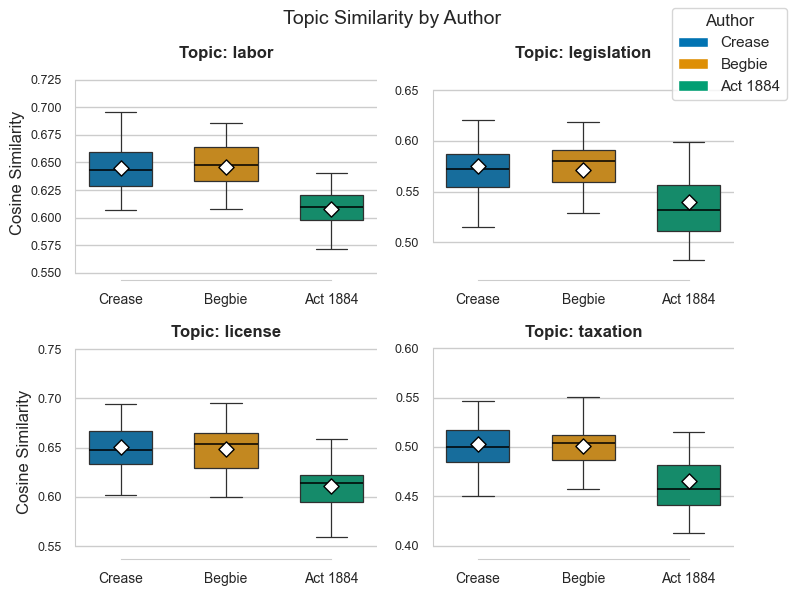

In [33]:
# prepare authors and topics
preferred_order = ['Crease', 'Begbie', 'Act 1884']
authors = [a for a in preferred_order if a in similarity_df['Author'].unique()]
topics = list(similarity_df['Topic'].unique())[:4] 

# Color Blind friendly palette
author_palette = sns.color_palette("colorblind", n_colors=len(authors))

sns.set(style="whitegrid", context="notebook")
fig, axes = plt.subplots(2, 2, figsize=(8, 6), sharey=False)

for i in range(4):
    ax = axes.flat[i]
    if i < len(topics):
        topic = topics[i]
        df_t = similarity_df[similarity_df['Topic'] == topic]

        # draw boxplot
        sns.boxplot(
            data=df_t,
            x='Author',
            y='Similarity Score',
            order=authors,
            palette=author_palette,
            width=0.6,
            fliersize=0,
            ax=ax,
            boxprops=dict(linewidth=0.9),
            medianprops=dict(linewidth=1.1, color='black'),
            whiskerprops=dict(linewidth=0.9),
            capprops=dict(linewidth=0.9)
        )

        # compute per-author means and overlay them
        means = df_t.groupby('Author')['Similarity Score'].mean().reindex(authors)
        x_positions = list(range(len(authors)))
        # plot white diamond with black edge so it stands out on colored boxes
        ax.scatter(x_positions, means.values, marker='D', s=60,
                   facecolors='white', edgecolors='black', zorder=10)

        # robust y-limits 
        vals = df_t['Similarity Score'].dropna()
        if len(vals) == 0:
            ymin, ymax = -1.0, 1.0
        else:
            q1 = vals.quantile(0.25)
            q3 = vals.quantile(0.75)
            iqr = q3 - q1
            if iqr == 0:
                whisker_low = float(vals.min())
                whisker_high = float(vals.max())
            else:
                whisker_low = float(q1 - 1.5 * iqr)
                whisker_high = float(q3 + 1.5 * iqr)

            span = max(whisker_high - whisker_low, 1e-6)
            pad = max(span * 0.08, 0.03)
            ymin = max(-1.0, whisker_low - pad)
            ymax = min(1.0, whisker_high + pad)
            if ymin >= ymax:
                mid = float(vals.median())
                ymin = max(-1.0, mid - 0.05)
                ymax = min(1.0, mid + 0.05)

        ax.set_ylim(ymin, ymax)

        ax.set_title(f"Topic: {topic}", fontsize=12, weight='semibold')
        ax.set_xlabel('')
        ax.set_ylabel('Cosine Similarity' if i % 2 == 0 else '')
        ax.axhline(0.0, color='grey', linestyle='--', linewidth=0.8, alpha=0.6)
        ax.tick_params(axis='x', rotation=0, labelsize=10)
        ax.tick_params(axis='y', labelsize=9)
        for spine in ax.spines.values():
            spine.set_linewidth(0.8)
        sns.despine(ax=ax, trim=True, left=False, bottom=False)
    else:
        ax.set_visible(False)

# Single legend for authors
legend_handles = [Patch(facecolor=author_palette[idx], label=authors[idx]) for idx in range(len(authors))]
fig.legend(handles=legend_handles, title='Author', loc='upper right', frameon=True)

plt.tight_layout(rect=[0, 0, 0.95, 0.96])
fig.suptitle('Topic Similarity by Author', fontsize=14, y=0.99)
plt.show()


### LLM and Zero-Shot Classification

Another powerful technique for text analysis is **zero-shot classification**, which allows us to classify text into predefined categories without requiring labeled training data, with the help of large language models (LLMs). This approach is particularly useful when we have a limited amount of labeled data or when the categories are not well-defined.

In addition to classifying text into specific categories, zero-shot classification can also be used to evaluate the stance of a text towards a particular issue or topic by **calculating the probability of the text belonging to each category**, the calculated probabilities will sum to 1 and they can be interpreted as the model's confidence in each category. In this workshop, we mainly focus on the second aspect, which allows us to assess the stance of each text. 

We will use the Hugging Face Transformers library to implement zero-shot classification using a pre-trained model **facebook/bart-large-mnli**. The model is trained on the Multi-Genre Natural Language Inference (MultiNLI) dataset, which contains pairs of sentences labeled with their relationship (pros, cons, or neutral). This allows the model to learn how to classify text based on its semantic meaning and context, which is particularly useful for our analysis of historical texts.

The key steps in our zero-shot classification process are as follows:

1. **Define the zero-shot pipeline**: We create a zero-shot classification pipeline using the pre-trained model and tokenizer from Hugging Face Transformers, and specify a hypothesis template "This snippet of a legal text {}" that will be used to generate hypotheses for classification.
2. **Define the candidate labels**: We define a set of candidate labels that represent the stance categories we want to classify the text into, which correspond to the basic stance categories we are interested in, such as "pro", "neutral" or "cons" the equal rights of Chinese immigrants.
3. **Classify the text**: We apply the zero-shot classification pipeline to each text in our corpus, generating a probability distribution over the candidate labels for each text.
4. **Investigate the results**: We analyze the classification results to identify the stance of each text, focusing on the highest probability label for each text. We also calculate the average probability for each candidate label across all texts to compare the overall stance of different authors and documents.

In [34]:
# Create the full snippets dictionary
act_1884_full = " ".join(act_1884)
crease_cases_full = " ".join(crease_cases)
begbie_cases_full = " ".join(begbie_cases)

full_cases = {"Crease": crease_cases_full, "Begbie": begbie_cases_full, "Act 1884": act_1884_full}

In [35]:
# We create a dictionary to hold the full snippets for each author
full_snippets = {}
for author, text in full_cases.items():
    # Tokenize using Spacy
    sentence = [sent.text for sent in nlp(text).sents]
    snippets = []
    for sent in sentence:
        if len(sent) > 30:  # Filter out short and meaningless sentences created by tokenization
            snippets.append(sent)
            
    full_snippets[author] = snippets

In [36]:
# Create a DataFrame to display snippet size by author
snippet_sizes = [{'Author': auth, 'Snippet Count': len(snippets)} for auth, snippets in full_snippets.items()]
snippet_sizes_df = pd.DataFrame(snippet_sizes)

# Display the DataFrame
print(snippet_sizes_df)

     Author  Snippet Count
0    Crease            262
1    Begbie            193
2  Act 1884             40


To ensure that the zero-shot classification results are meaningful, we carefully treat the candidate labels as prompts that guide the model's understanding of the stance categories. This allows us to leverage the model's ability to generalize and adapt to new tasks without requiring extensive retraining or fine-tuning. Here, we will use the following candidate labels:
- Pro: "This snippet of a legal text advocates for equal legal treatment of Chinese immigrants compared to white or European settlers, opposing racial discrimination"
- Neutral: "This snippet of a legal text describes the status or treatment of Chinese immigrants without expressing support or opposition to racial inequality"
- Cons: "This snippet of a legal text justifies or reinforces unequal legal treatment of Chinese immigrants relative to white or European settlers, supporting racially discriminatory policies"

However, we must note that this is also a major limitation of the zero-shot classification approach, as it relies on the quality and relevance of the candidate labels to the text being classified. If the labels are not well-defined or do not accurately reflect the stance categories, the classification results may be misleading or inaccurate. This is particularly important when working with historical texts, where the language and context may differ significantly from modern usage. Therefore, it is essential to carefully select and define the candidate labels to ensure that they accurately reflect the stance categories we are interested in.

In [37]:
# Create pipeline for zero-shot classification
warnings.filterwarnings("ignore")

zero_shot = pipeline(
    "zero-shot-classification",
    model="facebook/bart-large-mnli",
    tokenizer="facebook/bart-large-mnli",
    hypothesis_template="This snippet of a legal text {}."
)

labels = [
    "advocates for equal legal treatment of Chinese immigrants compared to white or European settlers, opposing racial discrimination",
    "describes the status or treatment of Chinese immigrants without expressing support or opposition to racial inequality",
    "justifies or reinforces unequal legal treatment of Chinese immigrants relative to white or European settlers, supporting racially discriminatory policies"
]

def get_scores(snippet):
    out = zero_shot(snippet, candidate_labels=labels)
    return dict(zip(out["labels"], out["scores"]))

Device set to use cpu


#### Sentence Approach

Another limitation of the zero-shot classification is that the number of tokens in the text is limited, which means that we cannot classify the entire text at once if it exceeds the token limit. To avoid exceeding the token limit, we can split the text into smaller chunks, such as sentences or windows of text, and classify each chunk separately.

The **sentence approach** is to classify each sentence in the text separately, which allows us to capture the stance of each sentence and its relationship to the overall text. This approach is particularly useful when the text is long or complex, as it allows us to analyze the stance of each sentence in isolation.

However, it has limitations in understanding the overall stance of the text, as it does not consider the context in which the sentences are used and therefore may capture too much variation in the stance of the text.

In [38]:
# Run zero-shot classification on the snippets from the Chinese Regulation Act 1884
act_scores = {}

for auth, snippets in full_snippets.items():
    scores = []
    for snip in snippets:
        score = get_scores(snip)
        scores.append(score)
    act_scores[auth] = scores

rows = []

for auth, snippets in full_snippets.items():
    for snip, score_dict in zip(snippets, act_scores[auth]):
        row = {
            "Author": auth,
            "Text": snip,
            "Pro": score_dict[labels[0]],
            "Neutral": score_dict[labels[1]],
            "Cons": score_dict[labels[2]]
        }
        rows.append(row)

# Create DataFrame to store the scores
df_scores = pd.DataFrame(rows)

In [39]:
# Print out the top 10 sentences with the highest "Pro" scores
top_pro_sentences = df_scores.nlargest(10, 'Pro')

print("\nTop 10 sentences with the highest 'Pro' scores:\n")

for _, row in top_pro_sentences.iterrows():
    wrapped_para = textwrap.fill(row['Text'], width=100)
    print(f"Author: {row['Author']}\nSentence: {wrapped_para}\nPro Score: {row['Pro']:.4f}\n")


Top 10 sentences with the highest 'Pro' scores:

Author: Begbie
Sentence: Rep. 354; Baker v. Portland, 5 Law 750; Teburcio Parrott's case, coram SAWYER and HOFFMAN, J.J.,
1880, and the Quene ordinance case, coram FIELD and SAWYER, J.J., 1879; the two latter cases
published in a separate pamphlet form, in which the opinions of Mr. Justices FIELD, HOFFMAN, SAWYER
and DEADY and other Judges whom they cite, all confirm this, that a State, or Provincial law
imposing special disabilities or unequal burdens on Chinamen is unconstitutional and void.
Pro Score: 0.9112

Author: Crease
Sentence: The treaty of 25th August, 1842, *Hertslet*, Vol. 6, ratified 26th June, 1843, p. 221, and Lord
Elgin's treaty of October, 1860, authenticated copies of which were produced in Court, secure to
Chinese coming into British dominions the same "full security for persons and property as subjects
of Her Majesty."
Pro Score: 0.8481

Author: Crease
Sentence: The treaties I have quoted between Great Britain and C

In [40]:
# Print out the top 10 sentences with the highest "Cons" scores
top_cons_sentences = df_scores.nlargest(10, 'Cons')

print("\nTop 10 sentences with the highest 'Cons' scores:\n")

for _, row in top_cons_sentences.iterrows():
    wrapped_para = textwrap.fill(row['Text'], width=100)
    print(f"Author: {row['Author']}\nSentence: {wrapped_para}\nCons Score: {row['Cons']:.4f}\n")


Top 10 sentences with the highest 'Cons' scores:

Author: Crease
Sentence: He reviewed the legislation against Chinese since confederation, contending it was levelled against
a particular race of aliens and, therefore, beyond provincial control, per *Gwynne*, J., in
*Citizens Insurance Co. v. Parsons*, 4 S. C. R., at p. 346.
Cons Score: 0.9671

Author: Crease
Sentence: And again, "A tax imposed by the law on these persons for the mere right to reside here, is an
appropriate and effective means to discourage the immigration of the Chinese into the State.
Cons Score: 0.9562

Author: Begbie
Sentence: The appellants' contention that the clause is merely intended to hamper or expel Chinamen is much
strengthened by considering the amount of the tax sanctioned, which is $150.00 per annum, whereas
the limit sanctioned by the Legislature in the case of any retail shop, however extensive or
lucrative its business, is only $10.00 per annum.
Cons Score: 0.9345

Author: Crease
Sentence: The palpab

In [41]:
# Group by author and calculate mean scores
mean_scores = df_scores.groupby("Author")[["Pro", "Neutral", "Cons"]].mean()
median_scores = df_scores.groupby("Author")[["Pro", "Neutral", "Cons"]].median()

print("Mean scores by author:")
print(mean_scores)

print("\nMedian scores by author:")
print(median_scores)


Mean scores by author:
               Pro   Neutral      Cons
Author                                
Act 1884  0.287633  0.197665  0.514702
Begbie    0.337704  0.287340  0.374956
Crease    0.291515  0.299332  0.409153

Median scores by author:
               Pro   Neutral      Cons
Author                                
Act 1884  0.309075  0.203331  0.494842
Begbie    0.342581  0.281552  0.331472
Crease    0.297104  0.273908  0.365707


In [42]:
df_scores['Wrapped Text'] = df_scores['Text'].apply(lambda t: wrap_text(t, width = 50))

fig = px.scatter(
    df_scores,
    x="Pro",
    y="Cons",
    color="Author",
    hover_data=["Wrapped Text"],
    title="Pros vs Cons Scores by Author",
    width=800,
    height=600
)

fig.update_traces(marker=dict(size=5))
fig.show()

#### Window Approach

In comparison to the sentence approach, the **window approach** is to classify larger chunks of text that contain multiple sentences with an overlapping context between windows. This allows us to capture the stance of the text in a more holistic way, while still being able to classify each window separately.

The limitation of this approach is that it may not capture the nuances of each sentence, as it treats the window containing multiple sentences as a single unit. However, it allows us to capture the overall stance of the text while still being able to classify each window separately.

Here, we define the function to split the text into overlapping windows of a specified size (maximum number of tokens) with a certain overlap (stride that overlap between consecutive windows). We then apply the zero-shot classification pipeline to each window and average the results to obtain the final classification for the entire text.

In [43]:
# Define a function to chunk text into overlapping windows
def chunk_into_windows(text, max_tokens=512, stride=128):
    
    # Break into sentences first for cleaner boundaries
    sents = sent_tokenize(text)
    windows = []
    current = ""
    for sent in sents:
        # Tentative window if we add this sentence
        cand = current + " " + sent if current else sent
        # Count tokens
        n_tokens = len(tokenizer.encode(cand, add_special_tokens=False))
        if n_tokens <= max_tokens:
            current = cand
        else:
            # finalize current window, then start new from overlapping tail
            windows.append(current)
            # keep the stride tokens from the end of the current window
            tail_ids = tokenizer.encode(current, add_special_tokens=False)[-stride:]
            tail_text = tokenizer.decode(tail_ids)
            current = tail_text + " " + sent
    if current:
        windows.append(current)
    return windows

In [44]:
# Run classification per author
rows = []
for author, text in full_cases.items():
    
    windows = chunk_into_windows(text, max_tokens=256, stride=64)
    
    # classify each window
    for win in windows:
        out = zero_shot(win, candidate_labels=labels, truncation=True, max_length=256)
        # Extract scores and labels
        score_dict = dict(zip(out["labels"], out["scores"]))
        rows.append({
            "Author": author,
            "Text": win,
            "Pro": score_dict[labels[0]],
            "Neutral": score_dict[labels[1]],
            "Cons": score_dict[labels[2]]
        })

all_scores = pd.DataFrame(rows)

In [45]:
# Print out the top 5 windows with the highest "Pro" scores
top_pro_windows = all_scores.nlargest(5, 'Pro')

print("\nTop 5 windows with the highest 'Pro' scores:\n")
for _, row in top_pro_windows.iterrows():
    wrapped_para = textwrap.fill(row['Text'], width=100)
    print(f"Author: {row['Author']}\nWindow: {wrapped_para}\nPro Score: {row['Pro']:.4f}\n")


Top 5 windows with the highest 'Pro' scores:

Author: Begbie
Window: from the constitution and the relation between the dominion and the provinces. but the judges in
those foreign courts have had a much longer and more varied experience on these topics than
ourselves ; their institutions are closely analogous in many judgment. respects, though, it is true,
contrasted in others to our own. And their opinions and reasonings being also founded on
international law, and, I take the liberty of saying, on natural equity and common sense, they are
entitled to great weight beyond the limits of their own jurisdiction. I shall only mention Lee Sing
v. Washburn, 20 Cal. Rep. 354; Baker v. Portland, 5 Law 750; Teburcio Parrott's case, coram SAWYER
and HOFFMAN, J.J., 1880, and the Quene ordinance case, coram FIELD and SAWYER, J.J., 1879; the two
latter cases published in a separate pamphlet form, in which the opinions of Mr. Justices FIELD,
HOFFMAN, SAWYER and DEADY and other Judges whom they cite

In [46]:
# Print out the top 5 windows with the highest "Cons" scores
top_cons_windows = all_scores.nlargest(5, 'Cons')

print("\nTop 5 windows with the highest 'Cons' scores:\n")
for _, row in top_cons_windows.iterrows():
    wrapped_para = textwrap.fill(row['Text'], width=100)
    print(f"Author: {row['Author']}\nWindow: {wrapped_para}\nCons Score: {row['Cons']:.4f}\n")


Top 5 windows with the highest 'Cons' scores:

Author: Crease
Window: act the legal presumption of innocence until conviction is reversed ; in every case the onus
probandi, though in a statute highly penal, is shifted from the informant on to the shoulders of the
accused, and he a foreigner not knowing one word of the law, or even the language of the accuser. In
other words, every Chinese is guilty until proved innocent—a provision which fills one conversant
with subjects with alarm; for if such a law can be tolerated as against Chinese, the precedent is
set, and in time of any popular outcry can easily be acted on for putting any other foreigners or
even special classes among ourselves, as coloured people, or French, Italians, Americans, or
Germans, under equally the same law. That certainly is interfering with aliens. The proposition that
it is a Provincial tax for revenue purposes, supposing it to be so intended under the provisions of
the Act, is so manifestly calculated to defeat

In [47]:
# Calculate the mean scores and median scores for each author
mean_scores = all_scores.groupby("Author")[["Pro", "Neutral", "Cons"]].mean()
median_scores = all_scores.groupby("Author")[["Pro", "Neutral", "Cons"]].median()

print("Mean scores by author:")
print(mean_scores)

print("\nMedian scores by author:")
print(median_scores)

Mean scores by author:
               Pro   Neutral      Cons
Author                                
Act 1884  0.227488  0.159862  0.612650
Begbie    0.336047  0.303727  0.360226
Crease    0.235292  0.260963  0.503745

Median scores by author:
               Pro   Neutral      Cons
Author                                
Act 1884  0.232503  0.145739  0.624099
Begbie    0.363180  0.290164  0.262902
Crease    0.196826  0.251595  0.506742


In [48]:
all_scores['Text'] = all_scores['Text'].apply(lambda t: wrap_text(t, width = 50))

fig = px.scatter(
    all_scores,
    x="Pro",
    y="Cons",
    color="Author",
    hover_data=["Text"],
    title="Pros vs Cons Scores by Author",
    width=800,
    height=600
)

fig.update_traces(marker=dict(size=5))
fig.show()

While both approach successfully identified that the Chinese Regulation Act of 1884 was more discriminatory towards Chinese people, and the relative positions of the three authors matched our expectations, we note that the zero-shot classification results are not deterministic, as they still depend on the specific language used in defining the candidate labels and the context in which the text is used.

For instance, the window

> ...act the legal presumption of innocence until conviction is reversed ; in every case the onus probandi, though in a statute highly penal, is shifted from the informant on to the shoulders of the accused, and he a foreigner not knowing one word of the law, or even the language of the accuser. In other words, every Chinese is guilty until proved innocent—a provision which fills one conversant with subjects with alarm; for if such a law can be tolerated as against Chinese, the precedent is set, and in time of any popular outcry can easily be acted on for putting any other foreigners or even special classes among ourselves, as coloured people, or French, Italians, Americans, or Germans, under equally the same law. That certainly is interfering with aliens. The proposition that it is a Provincial tax for revenue purposes, supposing it to be so intended under the provisions of the Act, is so manifestly calculated to defeat that object, by diminishing the numbers of the members of the persons to be affected by it, that it is difficult to regard it in that light, or in any other light than an indirect mode of getting rid of persons whom it affects out of the country.

is classified as "cons" by the zero-shot classification, which is not accurate, as it essentially reflects Crease's criticism of the discriminatory nature of the law, and there is no indication that he supports the unequal treatment of Chinese immigrants in this passage.

This highlights the limitations of zero-shot classification when dealing with historical legal texts: because the semantics and context of these texts are not obvious, and the rhetorical devices used in them are difficult for models to accurately capture. 

Such example emphasizes the importance of human interpretation and analysis in understanding the positions in historical texts, and also highlights the need for caution when selecting and defining candidate labels to ensure that these labels accurately reflect the position categories we are interested in. We should still only use machine learning techniques as an auxiliary tool in research.

### Putting It All Together

Now that we've examined topic alignment and quantified stances toward Chinese immigrants using zero‑shot classification, we synthesize the results to evaluate how thematic emphasis correlates with expressed stance. By combining TF‑IDF keywords, embedding‑based topic anchors, and zero‑shot probabilities, we assess whether focus on themes such as "labor", "taxation", or "legislation" corresponds with pro‑, neutral, or anti‑discriminatory language across authors and documents.



### Conclusion

### References

1. *Regina v. Wing Chong*, 1 B.C.R. Pt. II 150 (1885). 
2. *Wong Hoy Woon v. Duncan*, 3 B.C.R. 318 (1894). 
3. *Regina v. Mee Wah*, 3 B.C.R. 403 (1886).
4. *Regina v. Corporation of Victoria*, 1 B.C.R. Pt. II 331 (1888). 
5. *Quong Wing v. The King*, 49 S.C.R. 440 (1914). 
6. Law Society of British Columbia. (1896). *The British Columbia Reports: Being reports of cases determined in the Supreme and County Courts and in Admiralty and on appeal in the Full Court and Divisional Court* (Vol. 3). Victoria, BC: The Province Publishing Company.
7. Canada. Royal Commission on Chinese Immigration. (1885). *Report of the Royal Commission on Chinese Immigration: report and evidence*. Ottawa: Printed by order of the Commission. 
8. Thomas, P. (2012, June 12–14). Courts of last resort: The judicialization of Asian Canadian politics 1878 to 1913. Paper presented at the Annual Conference of the Canadian Political Science Association, University of Alberta, Edmonton, Canada. Retrieved from <https://cpsa-acsp.ca/papers-2012/Thomas-Paul.pdf> 
9. McLaren, J. P. S. (1991). The Early British Columbia Supreme Court and the "Chinese Question": Echoes of the rule of law. Manitoba Law Journal, 20(1), 107–147. Retrieved from <https://www.canlii.org/w/canlii/1991CanLIIDocs168.pdf> 
10. Chalkidis, I., Fergadiotis, M., Malakasiotis, P., Aletras, N., & Androutsopoulos, I. (2020). LEGAL-BERT: The Muppets straight out of Law School (arXiv:2010.02559). arXiv. <https://doi.org/10.48550/arXiv.2010.02559>
11. Loo, T. (1994). Crease, Sir Henry Pering Pellew. In Dictionary of Canadian Biography (Vol. 13). University of Toronto/Université Laval. Retrieved August 8, 2025, from <https://www.biographi.ca/en/bio/crease_henry_pering_pellew_13E.html> 
12. Williams, D. R. (1990). Begbie, Sir Matthew Baillie. In Dictionary of Canadian Biography (Vol. 12). University of Toronto/Université Laval. Retrieved August 8, 2025, from <https://www.biographi.ca/en/bio/begbie_matthew_baillie_12E.html> 
13. Ariai, F., Mackenzie, J., & De Martini, G. (2025). *Natural Language Processing for the legal domain: A survey of tasks, datasets, models and challenges*. arXiv preprint arXiv:2410.21306.